## 基于单树GP的符号回归（Symbolic Regression）

基于单树GP的符号回归是指使用遗传编程（GP）生成数学公式来逼近一组数据的关系，通过组合DEAP的Creator，Toolbox和Algorithms这三个模块即可实现。


### Creator类
Creator是一个工具类，其主要作用是创建新的类。在遗传编程中，通常需要自定义个体（Individual）和适应度（Fitness）类，因为不同的问题可能需要不同的适应度类型和个体结构。在DEAP中，我们可以使用creator来动态地创建这些类。

在下面的例子中，我们创建了一个最基本的单目标单树GP，可以使用base.Fitness和gp.PrimitiveTree来定义。

In [11]:
import math
import operator

from deap import base, creator, tools, gp


# 符号回归
def evalSymbReg(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    # 计算均方误差（Mean Square Error，MSE）
    mse = ((func(x) - x**2)**2 for x in range(-10, 10))
    return (math.fsum(mse),)

# 创建个体和适应度函数
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### Toolbox类
Toolbox的作用类似于一个调度中心，它负责“注册”各种操作和函数。在遗传编程中，这些操作通常包括交叉（crossover）、变异（mutation）、选择（selection）和评估（evaluation）。通过register，我们可以将这些操作和相关的函数绑定在一起，以供后续算法使用。

In [12]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))
pset.renameArguments(ARG0='x')

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

### Algorithms类
Algorithms模块提供了一些现成的遗传算法和遗传编程的实现。例如，eaSimple是一个简单的遗传算法，它可以处理基本的选择、交叉、变异和演化迭代。

In [13]:
import numpy
from deap import algorithms

# 定义统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# 使用默认算法
population = toolbox.population(n=100)
hof = tools.HallOfFame(1)
pop, log  = algorithms.eaSimple(population=population,
                           toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof, verbose=True)


   	      	                       fitness                        	                      size                     
   	      	------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max        	min	nevals	std   	avg 	gen	max	min	nevals	std    
0  	100   	71177.5	0  	3.19748e+06	0  	100   	314314	4.04	0  	7  	2  	100   	1.60574
1  	93    	43553.5	1  	162664     	0  	93    	29361.4	4.65	1  	12 	2  	93    	2.07545
2  	91    	96589.4	2  	2.95681e+06	0  	91    	398621 	5.45	2  	12 	2  	91    	3.01786
3  	94    	2.53799e+06	3  	2.41098e+08	0  	94    	2.39818e+07	5.75	3  	17 	2  	94    	3.00458
4  	91    	199260     	4  	3.51947e+06	0  	91    	704399     	5.77	4  	14 	2  	91    	2.85956
5  	92    	2.48158e+06	5  	2.2959e+08 	0  	92    	2.28354e+07	5.57	5  	15 	2  	92    	2.95044
6  	96    	2.57693e+06	6  	2.35463e+08	0  	96    	2.34184e+07	5.93	6  	17 	2  	96    	3.57563
7  	83    	368231     	7  	3.51947e+06	0  	83    	9793

由于DEAP重载了字符串运算符，因此可以直接输出结果。

In [14]:
print(str(hof[0]))

mul(neg(x), neg(x))


当然，我们也可以利用NetworkX库来对GP树进行可视化。

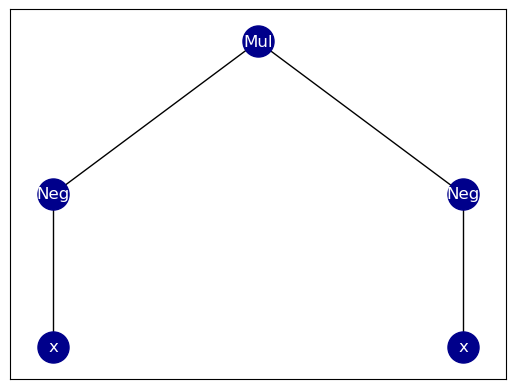

In [15]:
import networkx as nx
from deap.gp import graph
from networkx.drawing.nx_agraph import graphviz_layout

function_name = {
    'add':'Add',
    'sub':'Sub',
    'mul':'Mul',
    'neg':'Neg'
}

def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False


def plot_a_tree(tree=hof[0]):
    red_nodes = []
    purple_nodes = []
    blue_nodes = []
    for gid, g in enumerate(tree):
        if (
                hasattr(g, "value")
                and isinstance(g.value, str)
                and g.value.startswith("ARG")
        ):
            g.value = g.value.replace("ARG", "X")

        if g.name in function_name:
            g.name = function_name[g.name]

        if hasattr(g, "value") and (
                is_number(g.value)
                or (g.value.startswith("X") and int(g.value[1:]) < X.shape[1])
        ):
            # 基础节点
            red_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("X"):
            g.value = "$\phi$" + str(int(g.value.replace("X", "")) - X.shape[1] + 1)
            purple_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("$\phi$"):
            purple_nodes.append(gid)
        else:
            # 深蓝色节点
            blue_nodes.append(gid)
    nodes, edges, labels = graph(tree)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")
    red_nodes_idx = [nodes.index(n) for n in nodes if n in red_nodes]
    purple_nodes_idx = [nodes.index(n) for n in nodes if n in purple_nodes]
    blue_nodes_idx = [nodes.index(n) for n in nodes if n in blue_nodes]
    nx.draw_networkx_nodes(
        g, pos, nodelist=red_nodes_idx, node_color="darkred", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=purple_nodes_idx, node_color="indigo", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=blue_nodes_idx, node_color="darkblue", node_size=500
    )
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels, font_color="white")


plot_a_tree(hof[0])